In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/11.1.0'

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import haiku as hk
import jax
import optax
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial

import tensorflow as tf
import tensorflow_datasets as tfds

from jax_lensing.inversion import ks93inv, ks93

from jax_lensing.spectral import measure_power_spectrum, make_power_map

from astropy.io import fits

from tqdm.notebook import tqdm

In [4]:
resolution = 0.29
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel
map_size = 360
gaussian_path = "../../data/ktng/ktng_PS_theory.npy"
sigma_gamma = .148

ps_data = onp.load(gaussian_path).astype('float32')
ell = jnp.array(ps_data[0,:])
ps_halofit = jnp.array(ps_data[1,:] / pixel_size**2) # normalisation by pixel size
kell = ell /2/jnp.pi * 360 * pixel_size / map_size

# Interpolate the Power Spectrum in Fourier Space
ps_map = jnp.array(make_power_map(ps_halofit, map_size, kps=kell))

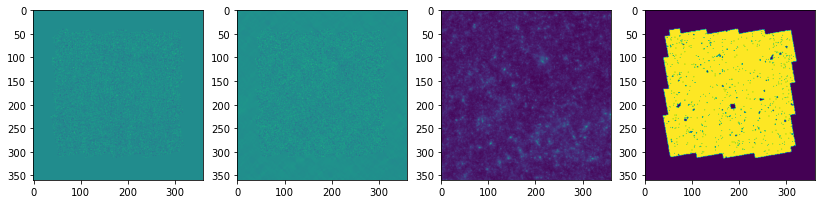

In [5]:
mask = fits.getdata('../../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits').astype('float32')

convergence = fits.getdata('../../data/ktng/ktng_kappa360v2.fits').astype('float32')
meas_shear = jnp.stack(ks93inv(convergence, jnp.zeros_like(convergence)), axis=-1)
std1 = fits.getdata('../../data/COSMOS/std1.fits').astype('float32').reshape((360,360,1))
std2 = fits.getdata('../../data/COSMOS/std2.fits').astype('float32').reshape((360,360,1))
sigma_gamma = jnp.concatenate([std1, std2], axis=-1)
meas_shear += sigma_gamma * jax.random.normal(jax.random.PRNGKey(0), meas_shear.shape)
#meas_shear += 0.148*np.random.randn(360,360,2)

mask = jnp.expand_dims(mask, -1)
sigma_mask = (1-mask)*1e10

masked_true_shear = meas_shear*mask

figure(figsize(14,5))
subplot(141)
imshow(masked_true_shear[..., 0])
subplot(142)
imshow(meas_shear[..., 1])
subplot(143)
imshow(convergence)
subplot(144)
imshow(mask[...,0])

In [6]:
def log_gaussian_prior(map_data, sigma, ps_map):
    map_data = map_data.reshape(360, 360)
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma**2))

gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

In [7]:
def log_likelihood(x, sigma, meas_shear, mask):
    """ Likelihood function at the level of the measured shear
    """
    ke = x.reshape((map_size, map_size))
    kb = jnp.zeros(ke.shape)
    model_shear = jnp.stack(ks93inv(ke, kb), axis=-1)
    return - jnp.sum((model_shear - masked_true_shear)**2/((sigma_gamma)**2 + sigma**2 + sigma_mask) )/2.

likelihood_score = jax.vmap(jax.grad(log_likelihood), in_axes=[0,0, None, None])

In [8]:
def total_score_fn(x, sigma):
    """ Compute the total score, combining the following components:
        gaussian prior, ml prior, data likelihood
    """
    data_score = likelihood_score(x, sigma, meas_shear, mask)
    gaussian_score = gaussian_prior_score(x, sigma, ps_map)
    return (data_score + gaussian_score).reshape(-1, 360*360)

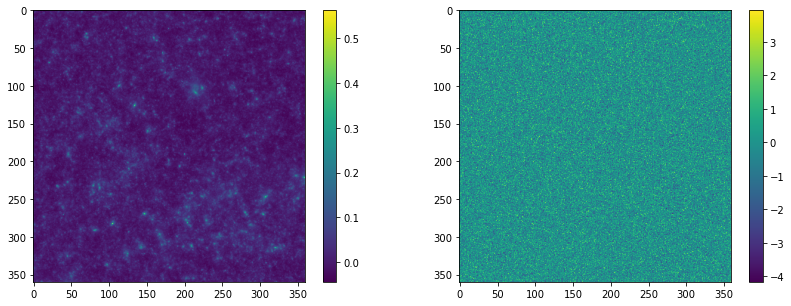

In [9]:
import numpy as onp
kappa_init = onp.random.randn(map_size, map_size) * 1.
sigma = jnp.zeros((1,1,1))

# Initialize with KS93
subplot(121)
imshow(convergence)
colorbar()
subplot(122)
imshow(kappa_init)
colorbar()

kappa_init = jnp.expand_dims(kappa_init, axis=0)

In [10]:
# compute MAP update
eps = 1e-5

@jax.jit
def update(x_old):
    gradient = total_score_fn(x_old, sigma)
    print(gradient)
    x_new = x_old + eps * gradient.reshape(1, 360, 360)
    return x_new

In [11]:
x_old = kappa_init.copy()
loss = []
samples = []

n_steps = 20000

for i in tqdm(range(n_steps)):
    x_new = update(x_old)
    samples.append(x_new)
    x_old = x_new
    
convergence_MAP = x_new[0,...]

  0%|          | 0/20000 [00:00<?, ?it/s]

Traced<ShapedArray(float32[1,129600])>with<DynamicJaxprTrace(level=0/1)>


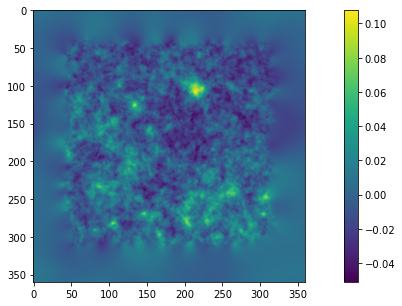

In [12]:
imshow(convergence_MAP)
colorbar()

In [13]:
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
from jax_lensing.samplers.score_samplers import ScoreHamiltonianMonteCarlo, ScoreMetropolisAdjustedLangevinAlgorithm
from jax_lensing.samplers.tempered_sampling import TemperedMC

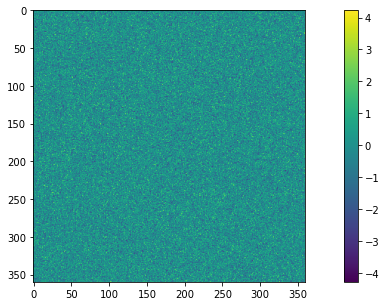

In [14]:
import numpy as onp

batch_size = 50

initial_temperature = 1.
initial_step_size = 0.013
min_steps_per_temp = 10

init_image, _ = ks93(mask[...,0]*masked_true_shear[...,0], mask[...,0]*masked_true_shear[...,1])
init_image = jnp.expand_dims(init_image, axis=0)
init_image = jnp.repeat(init_image, batch_size, axis=0)

init_image += (initial_temperature*onp.random.randn(batch_size,360,360))


imshow(init_image[2,...].reshape(360, 360))
colorbar()

In [15]:
%%time

def make_kernel_fn(target_log_prob_fn, target_score_fn, sigma):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=initial_step_size*(jnp.max(sigma)/initial_temperature)**0.5,
      #step_size=10*(np.max(sigma)/s0)**0.5,
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

tmc = TemperedMC(
            target_score_fn=total_score_fn,#score_prior,
            inverse_temperatures=initial_temperature*np.ones([batch_size]),
            make_kernel_fn=make_kernel_fn,
            gamma=0.98,
            min_temp=1e-3,
            min_steps_per_temp=min_steps_per_temp,
            num_delta_logp_steps=4)


#num_results = int(6e3)
num_burnin_steps = int(0)
#n = 3000

@jax.jit
def run_chains():
  samples, trace = tfp.mcmc.sample_chain(
        num_results=2,
        current_state=init_image.reshape([batch_size, -1]),
        kernel=tmc,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results=6000,#num_results//n - 1, # 6600
        trace_fn=lambda _, pkr: (pkr.pre_tempering_results.is_accepted,
                                 pkr.post_tempering_inverse_temperatures,
                                 pkr.tempering_log_accept_ratio),
        seed=jax.random.PRNGKey(8))

  return samples, trace

samples, trace = run_chains()

"""

num_steps = int(5e3)
output_steps = 2
num_burnin_steps = int(0)
samples, trace = tfp.mcmc.sample_chain(
          num_results=num_steps,
          current_state=init_image.reshape([batch_size, -1]),
          kernel=tmc,
          num_burnin_steps=0,
          num_steps_between_results=num_steps//output_steps,
          trace_fn=lambda _, pkr: (pkr.pre_tempering_results.is_accepted,
                                   pkr.post_tempering_inverse_temperatures,
                                   pkr.tempering_log_accept_ratio),
          seed=jax.random.PRNGKey(0))

"""
print(len(samples))
#######
######

/linkhome/rech/genpuc01/utb76xl/.local/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:5794: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


[Traced<ShapedArray(float32[50,129600])>with<DynamicJaxprTrace(level=2/1)>]
2
CPU times: user 22min 42s, sys: 1min 46s, total: 24min 29s
Wall time: 24min 30s


(50, 360, 360)


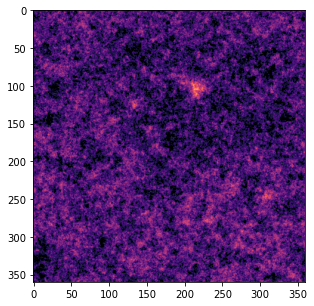

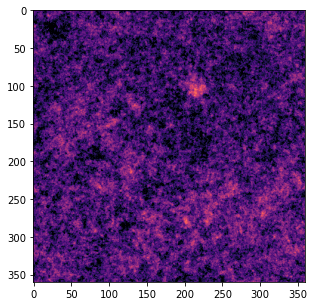

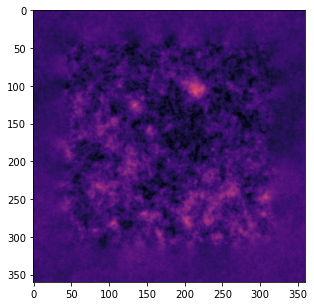

In [16]:
sol = samples[-1,...].reshape(-1, 360, 360)
np.save('../../results/gaussian/samples_9.npy', sol)

print(sol.shape)

figure()
imshow(sol[0, :].reshape(360,360), cmap='magma', vmin=-0.05, vmax=0.2)
figure()
imshow(sol[1, :].reshape(360,360), cmap='magma', vmin=-0.05, vmax=0.2)
figure()
imshow(sol.mean(0).reshape(360,360), cmap='magma', vmin=-0.05, vmax=0.2)

In [18]:
print(trace[1][-1])

[0.00419053 0.00473056 0.00436332 0.00291299 0.00615139 0.00394409
 0.00386521 0.00502613 0.00473056 0.00463595 0.0048271  0.00363791
 0.00666913 0.00410672 0.00463595 0.00427605 0.00445236 0.00386521
 0.00356515 0.00436332 0.00492561 0.00378791 0.00512871 0.00502613
 0.00463595 0.00602836 0.00410672 0.00492561 0.00567385 0.00473056
 0.00378791 0.00371215 0.00363791 0.00363791 0.00436332 0.00556037
 0.00523338 0.00436332 0.00445236 0.00419053 0.00512871 0.00473056
 0.00502613 0.00556037 0.00386521 0.00602836 0.00335549 0.00410672
 0.007378   0.00427605]


## Wiener Solution
Messenger Field algorithm

In [26]:
import jax.numpy as jnp
import numpy as np 
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import gc
import jax, sys
import importlib
from jax.ops import index, index_add, index_update

In [27]:
from jax_lensing import wiener_sampling, spectral, inversion

In [28]:
from astropy.io import fits
from jax_lensing.inversion import ks93inv

In [29]:
mask = mask[...,0]

In [30]:
test_kappa = convergence
test_e = masked_true_shear
ps_ktng_th = jnp.load("../../data/ktng/ktng_PS_theory.npy").astype('float32')

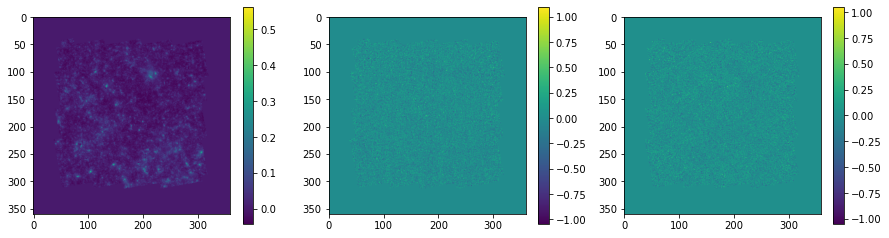

In [31]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(test_kappa*mask), plt.colorbar()
_ = plt.subplot(132), plt.imshow(test_e[:,:,0]), plt.colorbar()
_ = plt.subplot(133), plt.imshow(test_e[:,:,1]), plt.colorbar()

In [32]:
std_e1 = 0.148
#ncov_diag_e1 = np.ones(test_kappa.shape)*std_e1*std_e1*mask + np.abs(1.-mask)*1e10
#ncov_diag_e2 = np.ones(test_kappa.shape)*std_e1*std_e1*mask + np.abs(1.-mask)*1e10
ncov_diag_e1 = np.ones(test_kappa.shape)*std1[...,0]*std1[...,0]*mask + np.abs(1.-mask)*1e10
ncov_diag_e2 = np.ones(test_kappa.shape)*std2[...,0]*std2[...,0]*mask + np.abs(1.-mask)*1e10

In [33]:
resolution = 0.29 # arcmin/pixel
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel

In [34]:
k_map, ps_map = spectral.measure_power_spectrum(test_kappa+1j*test_kappa*0., pixel_size)
k_map = index_update(k_map, index[0], 0.)
ps_map = index_update(ps_map, index[128:], 0.)

k_map = k_map / 2 / jnp.pi * pixel_size * 360
ps_map = ps_map / pixel_size**2

In [35]:
kell = ps_ktng_th[0,:] / 2 / jnp.pi * pixel_size * 360
ps_th = ps_ktng_th[1,:] / pixel_size**2

k = np.arange(k_map.shape[0])
ps_th_interp = jnp.interp(k, kell, ps_th)
ps_th_interp = index_update(ps_th_interp, index[0], 0.)
ps_th_interp = index_update(ps_th_interp, index[128:], 0.)

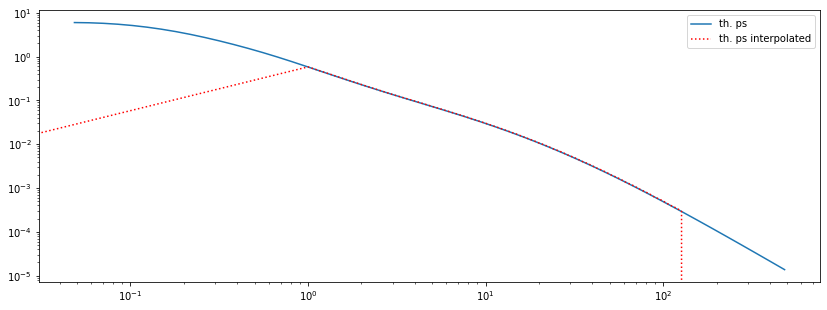

In [36]:
#plt.loglog(k_map, ps_map, '--', label='ps from map')
plt.loglog(kell, ps_th, label='th. ps')
plt.loglog(ps_th_interp, ':', color='red', label='th. ps interpolated')
plt.legend()

In [37]:
ps_th_map = jnp.fft.fftshift(spectral.make_power_map(ps_th_interp,360))
ps_th_map = index_update(ps_th_map, index[180,180], 0.)

In [38]:
# Use the thoertical Power Spectrum
ps_map = ps_th_map

In [39]:
%%time
wf_e1, wf_e2 = wiener_sampling.spin_wiener_filter_jit(test_e[:,:,0]+1j*test_kappa*0.,
                                                      test_e[:,:,1]+1j*test_kappa*0.,
                                                      ncov_diag_e1,
                                                      ncov_diag_e2,
                                                      ps_map,
                                                      ps_map*0.,
                                                      iterations=20)
wf_e, wf_b = inversion.ks93(wf_e1, wf_e2)

CPU times: user 833 ms, sys: 13.9 ms, total: 847 ms
Wall time: 542 ms


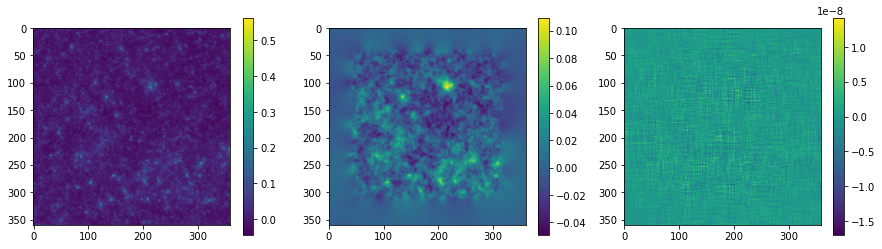

In [40]:
_ = plt.figure(figsize=(15,4))
_ = plt.subplot(131), plt.imshow(test_kappa), plt.colorbar()
_ = plt.subplot(132), plt.imshow(wf_e), plt.colorbar()
_ = plt.subplot(133), plt.imshow(wf_b), plt.colorbar()

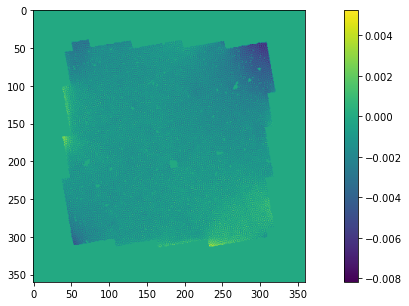

In [41]:
imshow(mask*(convergence_MAP-wf_e))
colorbar()

In [43]:
sol0 = np.load('../../results/gaussian/samples_1.npy')
sol1 = np.load('../../results/gaussian/samples_2.npy')
sol2 = np.load('../../results/gaussian/samples_3.npy')
sol3 = np.load('../../results/gaussian/samples_4.npy')
sol4 = np.load('../../results/gaussian/samples_5.npy')
sol5 = np.load('../../results/gaussian/samples_6.npy')
sol6 = np.load('../../results/gaussian/samples_7.npy')
sol7 = np.load('../../results/gaussian/samples_8.npy')
sol8 = np.load('../../results/gaussian/samples_9.npy')
sol = np.concatenate([sol0, sol1, sol2, sol3, sol4, sol5, sol6, sol7, sol8], axis=0)

In [45]:
resolution = 0.29 # arcmin/pixel
pixel_size = np.pi * resolution / 180. / 60. #rad/pixel

nsm_map = convergence_MAP
kp = convergence

gaussian_path = "../../data/ktng/ktng_PS_theory.npy"
ps_data_th = np.load(gaussian_path).astype('float32')

k_wiener, ps_wiener = spectral.measure_power_spectrum(wf_e, pixel_size)

k_nsm_map, ps_nsm_map = spectral.measure_power_spectrum(nsm_map, pixel_size)

k_map, ps_map = spectral.measure_power_spectrum(kp, pixel_size)

k_mean, ps_mean = spectral.measure_power_spectrum(sol[:,...].reshape(-1,360,360).mean(axis=0), pixel_size)

k_sample, ps_sample = spectral.measure_power_spectrum(sol[0,...], pixel_size)

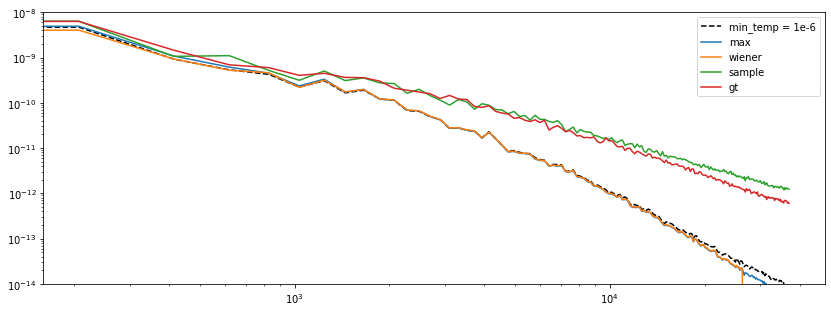

In [46]:
loglog(k_mean, ps_mean, label='min_temp = 1e-6', linestyle='--', color='k')
loglog(k_nsm_map, ps_nsm_map, label='max')
loglog(k_wiener, ps_wiener, label='wiener')
loglog(k_sample, ps_sample, label='sample')
loglog(k_map, ps_map, label='gt')
ylim([1e-14, 1e-8])
legend()

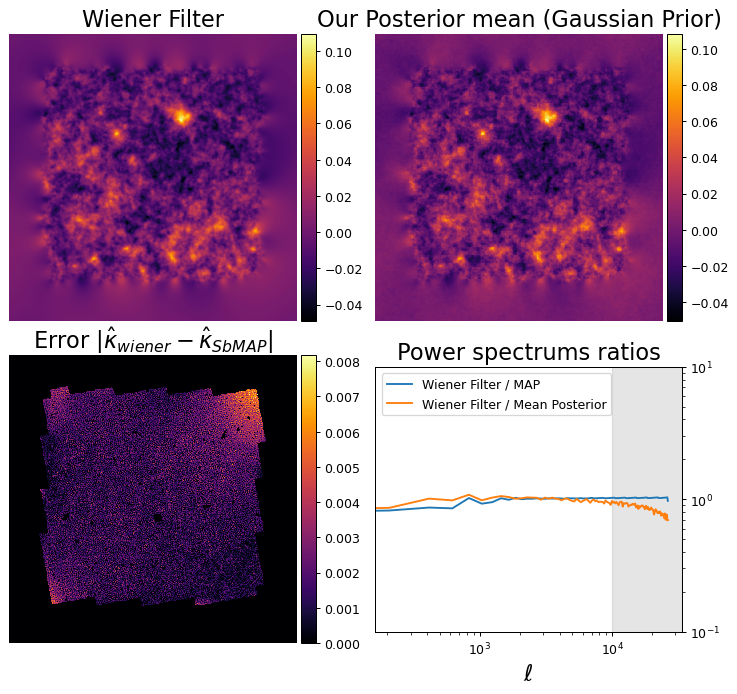

In [47]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

kwargs = dict(cmap='inferno')
fontsize=dict(fontsize=18)

#_ = plt.figure(figsize=(10,10))
fig, ax = plt.subplots(2,2, figsize=(8,8), dpi=90)

im = ax[0,0].imshow(wf_e, **kwargs)
ax[0,0].set_title('Wiener Filter', **fontsize)
ax[0,0].axis('off')#, colorbar()
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

#im = ax[0,1].imshow(nsm_map, interpolation='None', **kwargs)
im = ax[0,1].imshow(sol.mean(0), interpolation='None', **kwargs)
#ax[0,1].set_title('Score-based MAP (Gaussian Prior)', **fontsize)
ax[0,1].set_title('Our Posterior mean (Gaussian Prior)', **fontsize)
ax[0,1].axis('off')#,  plt.colorbar()
divider = make_axes_locatable(ax[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

im = ax[1,0].imshow(mask*np.abs(wf_e - nsm_map), interpolation='None', **kwargs)
#im = ax[1,0].imshow(mask*np.abs(wf_e - sol.mean(0)), interpolation='None', **kwargs)
ax[1,0].set_title(r'Error $\|\hat{\kappa}_{wiener}-\hat{\kappa}_{SbMAP}\|$', **fontsize)
#ax[1,0].set_title(r'Error $\|\hat{\kappa}_{wiener}-\hat{\kappa}_\mathrm{Post. mean}\|$', **fontsize)
ax[1,0].axis('off')#,  plt.colorbar()
divider = make_axes_locatable(ax[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

ps_ratio = ps_wiener/ps_nsm_map
ps_ratio_mean = ps_wiener/ps_mean
ax[1,1].set_title('Power spectrums ratios', **fontsize)
ax[1,1].set_aspect('equal')
ax[1,1].loglog(k_wiener[:128], ps_ratio[:128], label='Wiener Filter / MAP')
ax[1,1].loglog(k_wiener[:128], ps_ratio_mean[:128], label='Wiener Filter / Mean Posterior')
#ax[1,1].loglog(ps_wiener/ps_nsm_mean, '--', label='Wiener Filter / Posterior Mean')
ax[1,1].set_ylim([1e-1, 1e1])
ax[1,1].legend()
ax[1,1].yaxis.tick_right()
xmin, xmax = ax[1,1].get_xlim()
ax[1,1].add_patch(Rectangle((1e4, 1e-1), xmax-1e4, (1e1)-(1e-1), color='k', alpha=0.1))
ax[1,1].set_xlabel(r'$\ell$', fontsize=18)

plt.tight_layout(pad=0., w_pad=1., h_pad=-3.)

plt.savefig('gaussian-fig-5.pdf')

In [48]:
sol.shape

(450, 360, 360)

In [49]:
np.save('res/wf_e.npy', wf_e)

In [51]:
ell, ps_noise = spectral.measure_power_spectrum(0.148 * np.random.randn(360,360), pixel_size)
k_map, ps_map = spectral.measure_power_spectrum(kp, pixel_size)

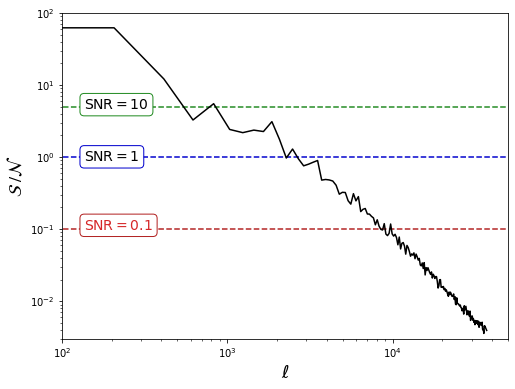

In [52]:
f, ax = plt.subplots(1,1, figsize=(8,6))

r = dict(xmin=left, xmax=right)

ax.hlines(y=5, **r, color='forestgreen', linestyle='--')
props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='forestgreen')
ax.text(x=0.05, y=0.74, s=r'$\mathrm{SNR=10}$', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.hlines(y=1, **r, color='mediumblue', linestyle='--')
props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='mediumblue')
ax.text(x=0.05, y=0.58, s=r'$\mathrm{SNR=1}$', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.hlines(y=0.1, **r, color='firebrick', linestyle='--')
props = dict(boxstyle='round', facecolor='white', alpha=1., edgecolor='firebrick')
ax.text(x=0.05, y=0.37, s=r'$\mathrm{SNR=0.1}$', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, color='tab:red')

ax.loglog(ell, ps_map/ps_noise, linewidth=1.5, color='k')

left, right = (1e2, 5e4)
ax.set_xlim([left, right])
ax.set_ylim([3*1e-3, 1e2])
ax.set_xlabel(r'$\ell$', fontsize=18)
ax.set_ylabel(r'$\mathcal{S~/N}$', fontsize=18)

savefig('snr.pdf')